# Le Teil earthquake epicenter location likelihood

<img src="images/logo-epos.png" style="margin:10px; height:80px;"/><img src="images/logo-esa.png" style="margin:10px; height:100px;"/><img src="images/logo-ipgp-upc.png" style="margin:10px; height:80px;"/>

The original version of this notebook was made by Antoine Lucas and Gregory Sainton. The current notebook was edited in 2023 by Leonard Seydoux (seydoux@ipgp.fr) to be used in the course "Earth Data Science" at the [Institut de Physique du Globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

## 1. Introduction

On November 11, 2019, a Mw 4.9 earthquake occured in the south of France, near the city of Le Teil. In this notebook, we will use the seismic data recorded by the RESIF network to estimate the epicenter location by a simple Monte Carlo method.

This notebook is planned for the second practical session of the course "Earth Data Science" at IPGP. It is based on the example made by Albert Tarantola [_Estimation of an Epicenter: Direct Use of the Probabilistic Method_](https://www.ipgp.fr/~tarantola/exercices/chapter_02/epicenter/Tarantola/CompleteDocument.pdf). We will use seven stations from the [French part of the EPOS network](https://www.epos-france.fr/) and explore some parameters of the problem. We will also use the InSAR data from the Sentinel-1 satellite to constrain the epicenter location. The production of the InSAR displacement map (available in the `data` repository) was made by Antoine Lucas using SNAP.

In [1]:
import os 

import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client

import solver

## 1. Introduction

Introducing to the topic of probabilistic methods, Albert Tarantola wrote in his book [Inverse Problem Theory](https://www.ipgp.fr/~tarantola/Files/Professional/Books/InverseProblemTheory.pdf), edited by Siam in 2005 (p.20):

<div style="padding-left: 20px; width: 90%; opacity:0.6;">

_Experiments suggest physical theory, and physical theory predict the outcome of experiments. The comparision of the predicted outcome and the observed outcome allows us to ameliorate the theory. It in the "physical theory" we include the physical parameters describing the system under study, then inverse problem theory is about the quantitative rules to be used for this comparison between predictions and observations._

</div>

Solving a _forward problem_ means to predict the error-free values of the observable parameters $d$ (e.g. travel times, temperature, pressure) that would correspond to a given model $m$. It can be formally written in the form

$$m \mapsto d = \mathcal{G}(m),$$

where $\mathcal{G}$ is the forward operator that contains the mathematical model of the physical system under study. In the problem of earthaquake epicenter likelihood estimation, the model parameters $m$ are the coordinates of the epicenter, simplified here in two dimensions:

$$m = (\lambda, \varphi) \in \mathbb{R}^2,$$

and the data parameters $d$ are the arrival times at the $N$ seismic stations that can be written as

$$d = (t_1, \ldots, t_N) \in \mathbb{R}^N.$$

Note that the travel times can be noisy due to several reasons (e.g., the noise in the data, wrong picking). The forward operator $\mathcal{G}$ is the travel time model that predicts the travel times $t_i$ for a given epicenter location $m$, and it is based on the knowledge of the velocity model of the medium. In this notebook, we will use a simple velocity model that does not depend on space, that is, the forward operator is linear and only depends on the distance between the epicenter and the station. 

> __Question 1.__ These notations match the ones of the book of Tarantola. According to the notations used in the lectures, how would you translate this problem into a machine learning problem? What are the input and output of the machine learning algorithm? What would you use as a first model?


## 2. Reading and preparing the data

### 2.1. Get event information from EPOS-France

Of course when inferring an earthquake epicenter, you have a bare idea of the event's location and time. Here we use the exact information provided by the BRGM (Bureau de Recherches Géologiques et Minières) that is available on the [website of EPOS-France](https://www.epos-france.fr/blog/2021/01/19/reponse-rapide-de-la-communaute-resif-au-tremblement-de-terre-mw-4-9-du-11-novembre-2019-au-teil/). We will then fetch the event information from the EPOS-France web service using the `obspy` package.

Note that RESIF was renamed EPOS-France in 2022. The web service is still available at the same address.

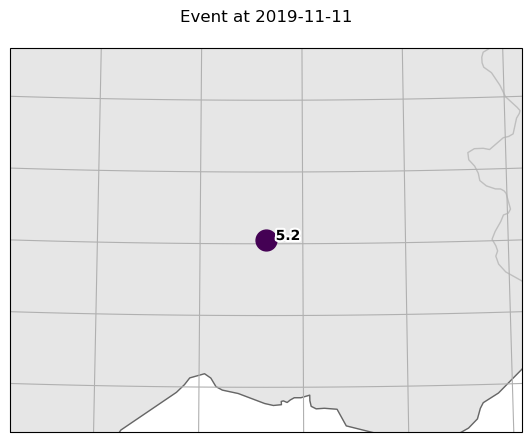

Origin
	       resource_id: ResourceIdentifier(id="smi:franceseisme.fr/origin/331941")
	              time: UTCDateTime(2019, 11, 11, 10, 52, 45, 840246) [confidence_level=89.99999762, uncertainty=0.005421964447]
	         longitude: 4.641592979 [confidence_level=89.99999762, uncertainty=0.02541704905]
	          latitude: 44.52632904 [confidence_level=89.99999762, uncertainty=0.03548455292]
	             depth: 2044.0418720000002 [uncertainty=53.976710589999996]
	        depth_type: 'from location'
	         method_id: ResourceIdentifier(id="LOCSAT")
	    earth_model_id: ResourceIdentifier(id="auvergne_taup-2.11")
	           quality: OriginQuality(associated_phase_count=262, used_phase_count=164, associated_station_count=185, used_station_count=119, standard_error=0.4831854149, azimuthal_gap=65.42434692, minimum_distance=0.05398160219, maximum_distance=4.894136906, median_distance=1.80831933)
	       origin_type: 'hypocenter'
	   evaluation_mode: 'manual'
	 evaluation_status: 'prelim

In [3]:
# Connect to the RESIF web service
client = Client("RESIF")

# Get the list of events at this time
# This is sufficient to constrain the search around Le Teil earthquake
events = client.get_events(
    starttime=obspy.UTCDateTime(2019, 11, 11, 10, 50),
    endtime=obspy.UTCDateTime(2019, 11, 11, 10, 55),
)

# Plot the events on a map
events.plot(projection="local", resolution="i")

# Get the only event in the list and show its origin
event = events[0]
event.origins[0]

### 2.2 Fetch available stations

We can now look for available seismic station around the time and place of the estimated earthaquake location. Note that with the seismic network in France, we have a good coverage of the country and may find already about 10 seismic station with a distance of less than 100km from the epicenter. We will use the `obspy` package to fetch the available stations.

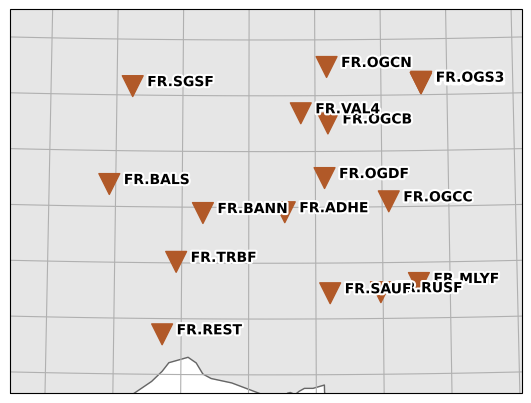

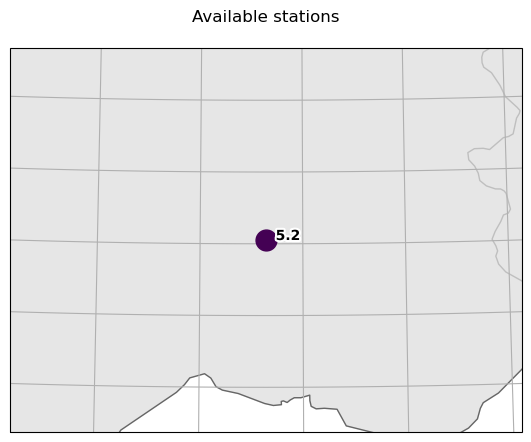

Inventory created at 2023-12-18T08:36:23.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?starttime=2019-11-11T10%3...
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (1):
			FR
		Stations (17):
			FR.ADHE (La Garde-Adhémar)
			FR.BALS (Balsièges)
			FR.BANN (fort de Banne)
			FR.MLYF (le Clot de Melly)
			FR.OGCB (Combovin)
			FR.OGCC (col des Casset)
			FR.OGCN (Le Chalon)
			FR.OGDF (Dieulefit)
			FR.OGS1 (Séchilienne)
			FR.OGS2 (Séchilienne)
			FR.OGS3 (Séchilienne)
			FR.REST (domaine de Restinclières)
			FR.RUSF (Rustrel)
			FR.SAUF (Saumane-de-Vaucluse)
			FR.SGSF (Siaugues-Sainte-Marie)
			FR.TRBF (grotte de Trabuc)
			FR.VAL4 (Valence)
		Channels (0):


In [4]:
# Look for station near the epicenter
inventory = client.get_stations(
    network="FR",
    channel="HHZ",
    starttime=event.origins[0].time - 5,
    endtime=event.origins[0].time + 125,
    latitude=event.origins[0].latitude,
    longitude=event.origins[0].longitude,
    maxradius=1,
    matchtimeseries=True,
)

# Plot inventory
fig = inventory.plot(projection="local", resolution="i", show=False)
events.plot(projection="local", resolution="i", fig=fig, title="Available stations")

# Show information
inventory

### 2.3. Download seismograms

We can now download the seismic waveforms from the seismic stations we have found in the previous step. We will use the `obspy` package to fetch the seismic records. We will work at the natural sampling rate of the stations, which is 100Hz for most of them. We will also use the `obspy` package to plot the seismic records.

> __Question 2.__ Give a basic description of the seismic records. What is the sampling rate of the seismic records? What is the duration of the seismic records? 

In [5]:
# Create an empty stream object
stream = obspy.Stream()

# Loop every network and station
for network in inventory:
    for station in network:

        try:

            # Get waveform data
            trace = client.get_waveforms(
                network.code,
                station.code,
                "*",
                "HHZ",
                starttime=event.origins[0].time - 5,
                endtime=event.origins[0].time + 125,
            )

            # Merge data
            trace.merge(fill_value="interpolate")

            # Add station location
            trace[0].stats.coordinates = {
                "latitude": station.latitude,
                "longitude": station.longitude,
            }

            # Add event information
            

            # Add to stream
            stream += trace[0]

        except:
            # If no data, print a message and continue
            print(f"No data for station {network.code}.{station.code}")

# Save stream as pickle file to keep the coordinates (not possible with miniseed)
stream.write("data/waveforms.pickle", format="PICKLE")

# Print stream information
print(stream)

# Print success message
print(f"Saved {len(stream)} traces in ./data/waveforms.pickle")

# Plot the stream
stream.plot(
    type="section",
    orientation="horizontal",
    dist_degree=True,
    ev_coord=(event.origins[0].latitude, event.origins[0].longitude),
);

No data for station FR.ADHE
No data for station FR.OGS1
No data for station FR.REST
No data for station FR.SGSF
No data for station FR.TRBF
No data for station FR.VAL4


FileNotFoundError: [Errno 2] No such file or directory: 'data/waveforms.pickle'

### 2.4. Plot the waveforms and pick the P-wave arrival times

Now we can explore the data content and pick the P-wave arrival times. Picking seismic arrival times is a difficult task that requires a lot of experience. Usually, this is done by a human expert. Here we will use the `obspy` package to pick the P-wave arrival times, using a old-school method based on the STA/LTA ratio (short-time average over long-term average). We will use the `obspy` package to plot the seismic records and the picked arrival times.

> __Question 3.__ The STA/LTA method is a simple method to pick the P-wave arrival times. What are the advantages and disadvantages of this method? What values of the STA/LTA ratio would you use to pick the P-wave arrival times?

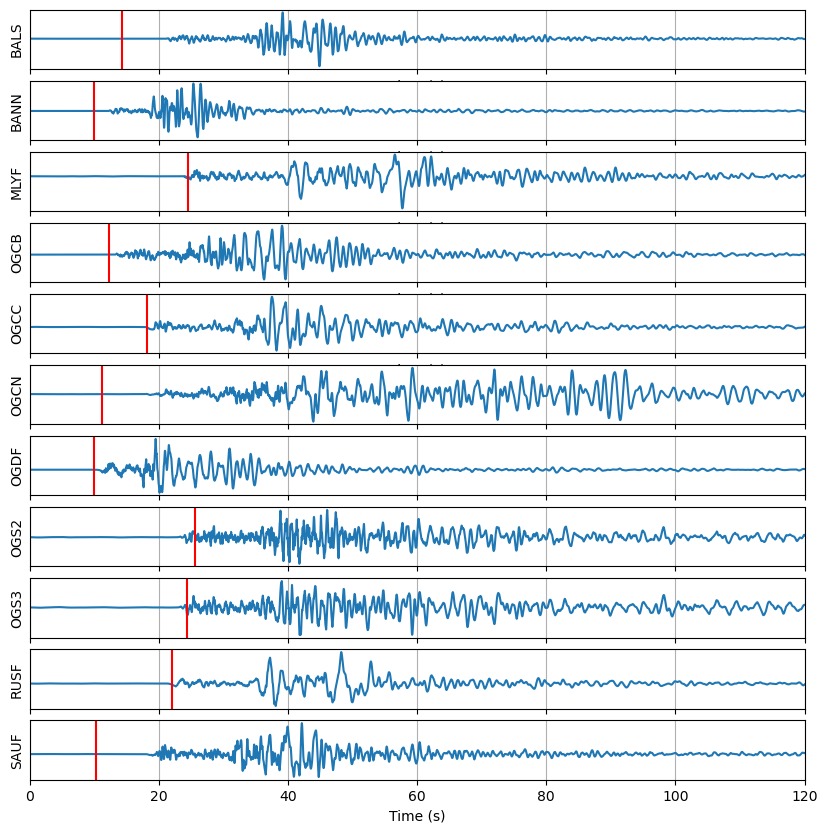

In [99]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Read waveforms from pickle file
stream = obspy.read("data/waveforms.pickle")

# Define the short and long term average
short_term_average = 1
long_term_average = 10

# Get firt arrive time
for trace in stream:
    # Convert short and long term average to number of samples
    n_sta = int(short_term_average * trace.stats.sampling_rate)
    n_lta = int(long_term_average * trace.stats.sampling_rate)

    # Get trigger
    trigger = classic_sta_lta(trace.data, n_sta, n_lta)

    # Get onset from trigger function
    onset = trigger_onset(trigger, 2, 0.5)

    # If onset is found, add it to the trace
    if np.size(onset) > 0:
        onset = onset[0, 0]
        trace.stats.onset = onset / trace.stats.sampling_rate
    else:
        # Print a message if no onset is found
        print(f"No onset found for {trace.id}")

# Plot waveforms
fig, axes = plt.subplots(len(stream), sharex=True, figsize=(10, 10))
for ax, trace in zip(axes, stream):
    ax.plot(trace.times(), trace.data)
    ax.axvline(trace.stats.onset, color="r")
    ax.set_xlim(0, 120)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(trace.stats.station)
    ax.grid()

## 3. Inverse problem

### 3.1. Theoretical background

The coordinates of the seismic stations and the velocity of the _P_ wave are assumed which means that the velocities uncertainties are supposed to be negligible in comparison with the uncertainties of the observed arrival times. For a source located at the position $x = (\lambda, \varphi)$, the predicted arrival times $\hat{t}_i$ of the seismic wave recorded at station $i$ located at $x_i = (\lambda_i, \varphi_i)$ are predicted by the forward model $\mathcal{G}$ as

$$ \hat{t}_i = \mathcal{G}_i(x_i) = \frac{\mathcal{D}(x, x_i)}{v},$$

where the velocity $v$ is considered to be constant for the sake of simplicity. The function $\mathcal{D}$ is the great circle distance between the source and the station. From the lecture, we know that the _posterior_ information $\sigma(m)$ is a combination of all informations we have which can be expressed as 

$$\sigma(m) = k \rho(m) \mathcal{L}(m)$$

where $k$ is a normalization constant, $\rho(m)$ is the *a priori* and $\mathcal{L}(m)$ is the likelihood function. If we consider the uncertainties to be Gaussian with a standard deviation $\nu$, the likelihood function $\mathcal{L}(m)$ is expressed as:

$$ \mathcal{L}(m) = k' \exp\left( -\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-\hat{t}_i}{\nu}\right)^2 \right)$$

where $k'$ is a normalization constant. Injecting the likelihood function into the posterior information, we obtain:

$$
\sigma(m) = kk' \rho(m) \exp\left( -\frac{1}{2} \sum_{i=1}^{n} \left(\frac{t_{i}-\hat{t}_i}{\nu}\right)^2\right)
$$

For now we can take the a priori information $\rho(m)$ as a constant, since we do not have yet a priori information about the epicenter location for now. We will come back to this point later. The posterior information $\sigma(m)$ is then proportional to the likelihood function $\mathcal{L}(m)$, which means that the maximum of the posterior information is also the maximum of the likelihood function. We can then maximize the likelihood function to find the epicenter location, denoted $m^*$, that best fits the data. The maximum of the likelihood function is obtained by maximizing the following function:

$$
m^* = \arg\max\limits_{m}\, \exp\left(-\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-\hat{t}_i}{\nu}\right)^2\right)
$$

### 3.2. Estimation of the epicenter location from few stations

At first we will work with (deliberately) too few seismic stations which naturally brings biases in the estimation of the epicenter location. We will select three stations located in a line along the Rhône valley: OGCN, OGCB, and OGDF. 

In [102]:
# Extract selected stations
stream_line = stream.select(station="OG*")

# Remove OGCC station
stream_line = stream_line.remove(stream_line.select(station="OGCC")[0])
stream_line = stream_line.remove(stream_line.select(station="OGS2")[0])
stream_line = stream_line.remove(stream_line.select(station="OGS3")[0])

# Print stream information
stream_line

3 Trace(s) in Stream:
FR.OGCB.00.HHZ | 2019-11-11T10:52:40.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 13000 samples
FR.OGCN.00.HHZ | 2019-11-11T10:52:40.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 13000 samples
FR.OGDF.00.HHZ | 2019-11-11T10:52:40.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 13000 samples

Now the idea is to sample the probability density $\mathcal{L}(m)$ at random positions $m$ to have an idea of the entire probability distribution. 

### 3.3 Plot the likelihood

Compute here the likelihood function $\mathcal{L}(m)$ for a grid of epicenter locations $m$ and plot it. You can use the `matplotlib` package to plot the likelihood function.

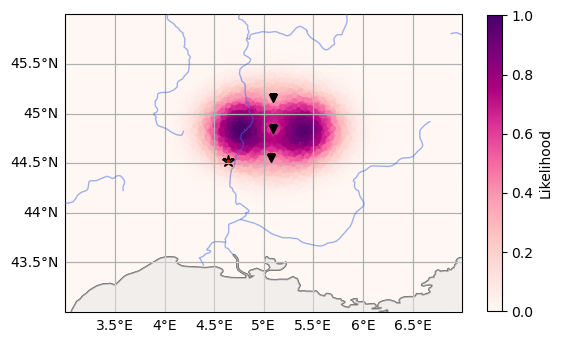

In [191]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_gaussian(
    stream_line, shots=40000, uncertainty=10, wavespeed=3, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream_line, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=9)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Show
plt.show()

### 3.3. Working with all the stations

Now we will work with all the stations we have found in the previous step.

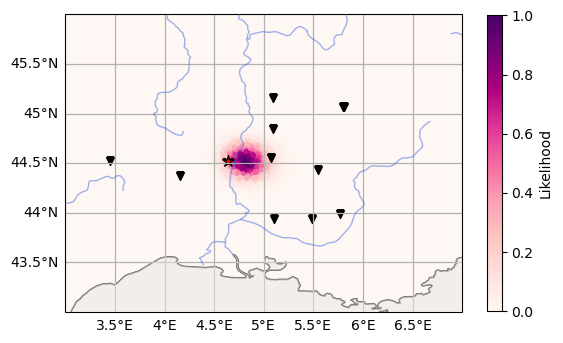

In [192]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_gaussian(
    stream, shots=40000, uncertainty=10, wavespeed=3, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=9)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Show
plt.show()

As we can see on these plots, the time picking for OGCC is erroneous. Actually, this means that the problem is statistically biaised. In fact, we introduced an aberrant arriving time ```Tobs```  at  one station.  Because the Gaussian assumption is used, the result is very sensitive to big errors (even if there is a small number of them).

### 3.4. Deal with biases in dataset

Your are invited to consider changing the Gaussian model by the more robust Laplacian model,
and/or introducing a priori information.  

First, here is the Laplace distribution:

$\begin{equation}
L_L(m) = k.exp{\left[-\sum\limits_{i=1}^{n} \frac{\lvert t_{i}-t_{obs}\lvert}{\sigma_i}\right]} \tag{6}
\end{equation}$

where $k$ is a normalization constant. For sake of simplicity of this lab, we can ignore it. 

#### Questions

1. Modify the function ```MC_Gauss(...)``` to ```MC_Laplace(...)``` to use the Laplacian distribution.
2. Make your function run over the parameters space and plot the results
3. Which station is concerned by the biais?

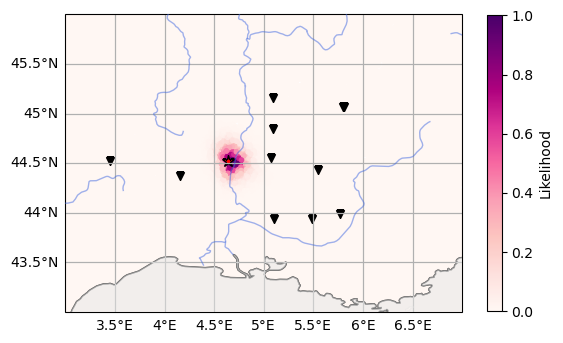

In [196]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_laplacian(
    stream, shots=40000, uncertainty=6, wavespeed=4, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=9)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Show
plt.show()

#### Comments
Accounting for a more robust model, the inversion is somewhat less biaised and the result is better. 

### 3.5. Introducing a priori information from InSAR

Now, we will add a priori information from surface displacement obtained from Sentinel-S1 InSAR between the Nov. 6 and Nov. 12. First, we need to read the displacement map. The results are contained in a GeoTiff file ``InSAR_S1/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.tif``. This file comes with Geo Tags in Exifs. For reading these metadata various libs exist, such as ``rasterio``, ``georaster``, ``osgeo``. ``PIL`` and ``OpenCV`` are other image processing libraries that could be also considered. Because you may not have these libs installed, we made a copy into a PNG flat file that can be directly read with ``matplotlib`` or ``scipy`` that should be present in your system. Unfortunately, the Geo tags are no more present into the file and the image footprint in Lamber 93 system needs to be manually provided as:

```python
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]
```

Note that we do a simplistic remapping of the geographic coordinates which is sufficient for the purpose of the lab but a proper warping should be done for accurate results. For those interested in exploring the geospatial approach   the mandatory libs need to be installed. You would need the ``Scripts/ConvertProj.ipynb`` for converting the geographic coordinates into Lambert-93.

In [56]:
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]

**Hint**

The ``.imread`` function of ``matplotlib`` returns a ``numpy.array``

In [55]:
im = plt.imread('data/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.png')

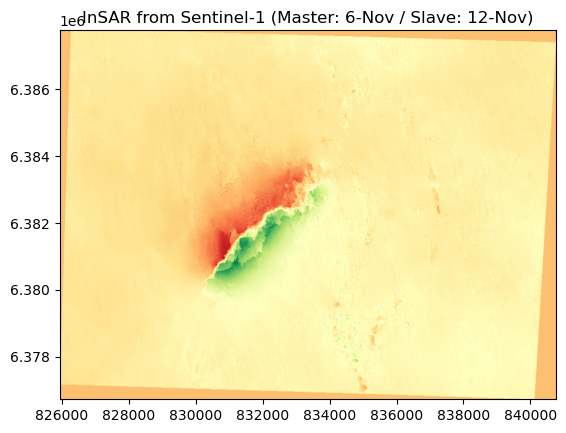

In [58]:
fig, ax = plt.subplots()
ax.imshow(im,interpolation='bilinear', cmap=cm.RdYlGn,
               extent=[ul[0], lr[0],ul[1], lr[1]])
plt.title('InSAR from Sentinel-1 (Master: 6-Nov / Slave: 12-Nov)')
ax.set_aspect('equal', 'box')

Let's use this location as a prior on the inversion. We take the center of the displaced area in X coordinate (named ``xx``) and we take an uncertainties sigma of  the lateral extend (i.e., ``sigma2``). Then we compute a prior with a Gaussian distribution, centered in ``xx`` with a standard deviation ``sigma2``. We test with ```MC_Gauss(...)``` function and the ``problem2`` defined above : 
```python
xx=832000;
sigma2=2000;
```

<AxesSubplot:title={'center':'EQ estimation from 3 stations, with Prior'}, xlabel='Easting (km)', ylabel='Northing (km)'>

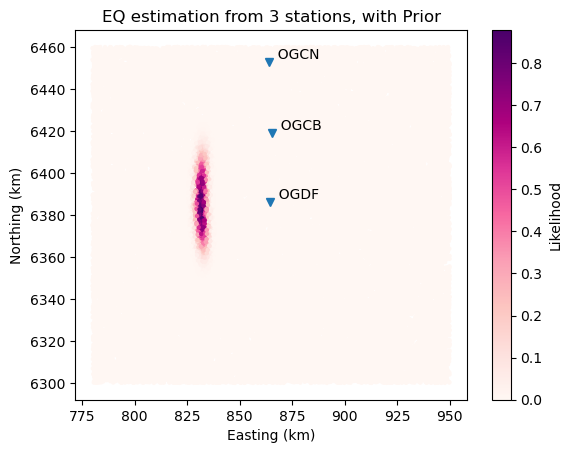

In [59]:
xx=832000; 
sigma2=2000;
#yy=6382000

gobs_InSar = MC_Gauss(problem1, param_space)


fprior =    np.exp( -0.5* (gobs_InSar[:,0] - xx)**2/sigma2**2)

gobs_InSar[:,2] = fprior*gobs_InSar[:,2];
title = 'EQ estimation from 3 stations, with Prior'
plot_dist_obs(gobs_InSar, problem1, title)

#### Comments

Providing an a priori when the observable are biased (i.e., problem1) is strongly helpfull.

Now, let's play with problem2:

<AxesSubplot:title={'center':'EQ estimation from 7 stations, with Prior and error'}, xlabel='Easting (km)', ylabel='Northing (km)'>

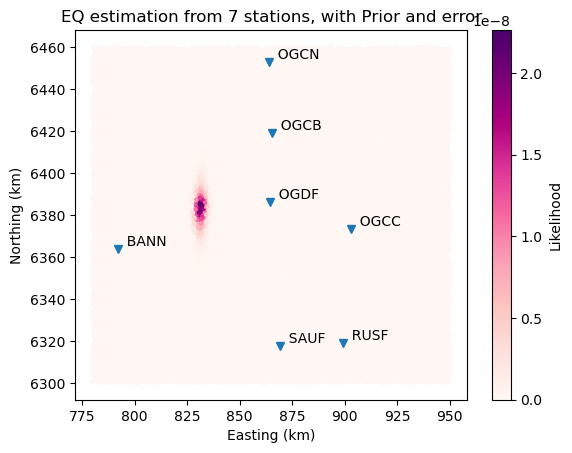

In [60]:
gobs_InSar2 = MC_Laplace(problem2, param_space)
fprior =    np.exp( -0.5* (gobs_InSar2[:,0] - xx)**2/sigma2**2)
gobs_InSar2[:,2] = fprior*gobs_InSar2[:,2];
title = 'EQ estimation from 7 stations, with Prior and error'
plot_dist_obs(gobs_InSar2, problem2, title)

The solution is helped by the a priori knowledge of the problem. 

### 3.6 Further investigations 
First, let evaluate our solution with the actual one.

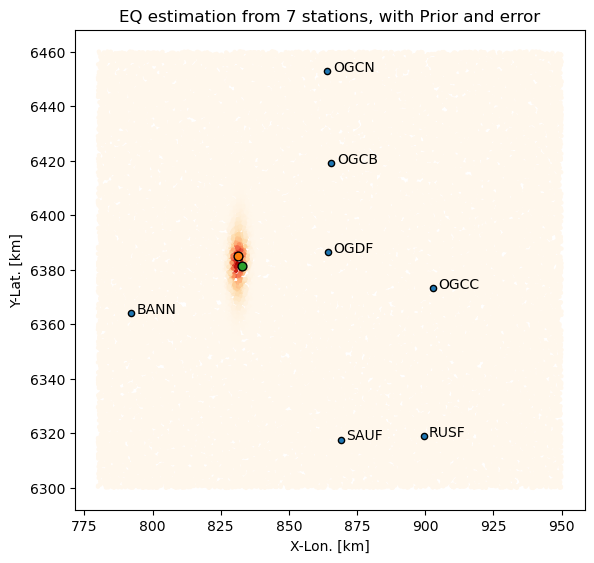

In [61]:
# Here we search for the maximum probability, but keep in mind that the less probable solution are still valid.

ind = np.where(gobs_InSar2[:,2]==np.max(gobs_InSar2[:,2]))
Xprob = gobs_InSar2[ind,0] ; Yprob = gobs_InSar2[ind,1]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(gobs_InSar2[:,0]/1000., gobs_InSar2[:,1]/1000., edgecolors='none', 
               s=10, c=gobs_InSar2[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem2["longitude"]/1000., problem2["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem2.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

We see that our most probable solution is closed to the actual's. In any case, the actual solution is inside our most probable area. So even with our simplifications and biais for one station, our solution is acceptable.

Now, let's retrieve the correct time arrival at ``OGCC`` from our most probable location.

In [62]:
Xstep=problem2[problem2["station"].isin(["OGCC"])]["longitude"].to_numpy()
Ystep=problem2[problem2["station"].isin(["OGCC"])]["latitude"].to_numpy()
Tcal = np.sqrt((Xprob - Xstep)**2 + (Yprob - Ystep)**2)/param_space["v"]
problem_corr = problem2.copy()
problem_corr.head()

,station,latitude,longitude,elevation,filename,Tobs,sigma
0,BANN,6363993.0,792139,447.0,Unknown,7.0,2.0
1,OGCB,6418973.0,865628,738.0,Unknown,8.7,4.0
2,OGCC,6373282.0,902942,1250.0,Unknown,53.4,1.2
3,OGCN,6452684.7,864138,300.0,Unknown,14.2,3.0
4,OGDF,6386363.0,864306,709.0,Unknown,6.6,1.0


In [21]:
problem_corr.loc[problem_corr["station"].isin(["OGCC"]), 'Tobs'] = Tcal
data_picking.loc[data_picking["station"].isin(["OGCC"]), 'Tobs'] = Tcal

problem_corr.head()

,station,latitude,longitude,elevation,filename,Tobs,sigma
0,BANN,6363993.0,792139,447.0,./data/csv/FR_BANN_00_100.0_2019-11-11T10_50_1...,7.000000,2.0
1,OGCB,6418973.0,865628,738.0,./data/csv/FR_OGCB_00_100.0_2019-11-11T10_50_1...,8.700000,4.0
2,OGCC,6373282.0,902942,1250.0,./data/csv/FR_OGCC_00_100.0_2019-11-11T10_50_1...,13.559479,1.2
3,OGCN,6452684.7,864138,300.0,./data/csv/FR_OGCN_00_100.0_2019-11-11T10_50_1...,14.200000,3.0
4,OGDF,6386363.0,864306,709.0,./data/csv/FR_OGDF_00_100.0_2019-11-11T10_50_1...,6.600000,1.0


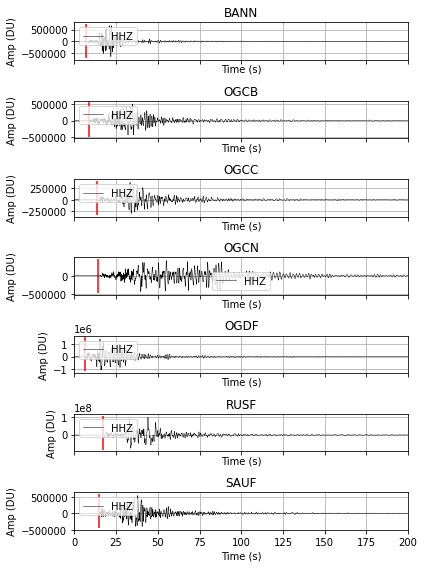

In [22]:
plot_trace(problem_corr)

Let's play with some parameter of the model, for example, let's try v = 5041;

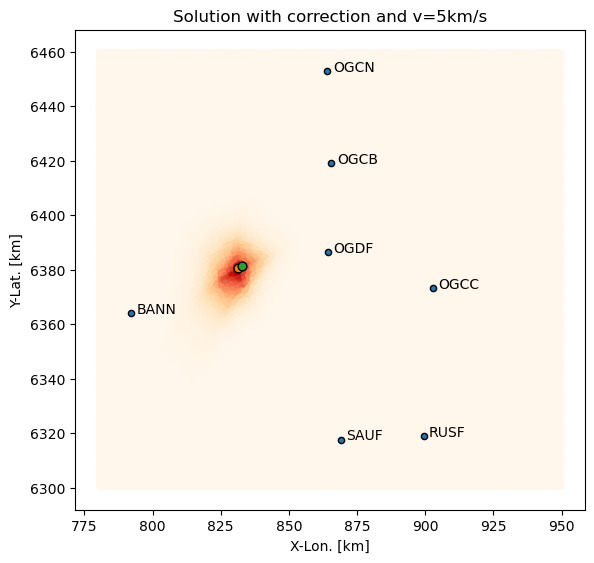

In [63]:
param_space = {}

param_space["Xmin"] = 7.8e5 
param_space["Xmax"] = 9.5e5;
param_space["Ymin"] = 6.3e6; 
param_space["Ymax"] = 6.46e6;
param_space["n_run"]= 5e5;  
param_space["v"]    = 5041; 

sol_corr = MC_Laplace(problem_corr, param_space)

ind = np.where(sol_corr[:,2]==np.max(sol_corr[:,2]))
Xprob = sol_corr[ind,0] ; Yprob = sol_corr[ind,1]


title='Solution with correction and v=5km/s'
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(sol_corr[:,0]/1000., sol_corr[:,1]/1000., edgecolors='none', 
               s=10, c=sol_corr[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem_corr["longitude"]/1000., problem_corr["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem_corr.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

Our solution becomes really close the real one.

## Some references

CNRS report (in French):
https://www.cnrs.fr/fr/seisme-du-teil-vers-une-reevaluation-du-risque-sismique-en-france-et-en-europe-de-louest

Journal article (in English): https://doi.org/10.1038/s43247-020-0012-z